In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import matplotlib.pyplot as plt

import math
import numpy as np
import pandas as pd
#import seaborn as sns

#from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
import torch.utils.checkpoint as checkpoint

import torchvision
from torchvision.transforms import v2

import warnings
import time
import functools
import copy
import os

seed = 1001
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)
warnings.simplefilter('ignore', UserWarning)

In [2]:
import torchquantum as tq
from torchquantum.measurement import expval_joint_analytical

In [3]:
print(torch.__version__)
print(tq.__version__)

2.5.1+cu124
0.1.7


In [4]:
n_gpu = torch.cuda.device_count()
print(n_gpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print([torch.cuda.get_device_name('cuda:'+str(i)) for i in range(n_gpu)])

1
['NVIDIA GeForce RTX 4090']


In [5]:
data = torchvision.datasets.MNIST(root='./data', train=True, download=True)
data_tr, label_tr = data.train_data, data.train_labels
data = torchvision.datasets.MNIST(root='./data', train=False, download=True)
data_te, label_te = data.test_data, data.test_labels
print(data_tr.shape, data_te.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


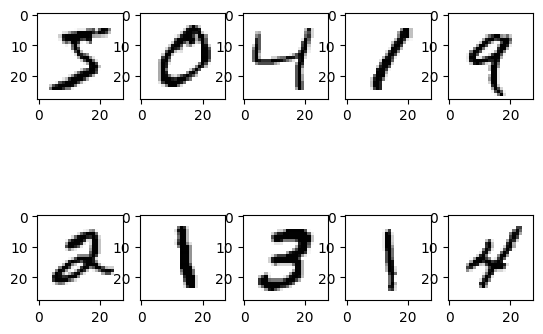

In [6]:
num = 10
for i in range(num):
    ax = plt.subplot(2,num//2,i+1)
    ax.imshow(data_tr[i].detach().numpy(), cmap='gray_r')

In [7]:
dataset_name = 'mnist'
n_class = len(np.unique(label_tr))

In [8]:
n_qubits = 8
n_depth_per_block = 200
n_qnn = 16

#assert n_qubits%2==0
n_half_qubits = n_qubits//2 # 3
n_latter_half_qubits = n_qubits-n_half_qubits

In [9]:
class ConstCoeffLayer(nn.Module):
    def __init__(self, coeff):
        super().__init__()
        self.coeff = coeff
    def forward(self, x):
        ret = x * self.coeff
        return ret

In [10]:
def calc_exp_val(qdev, obs):
    assert len(obs)==n_qubits
    state2 = qdev.states.clone()
    for i in range(n_qubits):
        if obs[i]=='I':
            continue
        elif obs[i]=='X':
            mat = torch.tensor([[0,1],[1,0]])
        elif obs[i]=='Y':
            mat = torch.tensor([[0,-1j],[1j,0]])
        elif obs[i]=='Z':
            mat = torch.tensor([[1,0],[0,-1]])
        state2 = tq.functional.apply_unitary_bmm(state2, mat, [i])
    state1 = qdev.states.clone()
    exp_val = torch.einsum("bij...k,bij...k->b", state1.conj(), state2).real
    # to confirm the calculation of expectation values
    if False:
        bra = qdev.get_states_1d().clone().conj()
        ket = torch.reshape(state2, [bsz, 2**n_qubits])
        tmp_exp_val = torch.sum(bra*ket,dim=1).real # (bsz,dim) => (bsz)
        assert np.allclose(tmp_exp_val.detach().cpu().numpy(),exp_val.detach().cpu().numpy(),rtol=1e-5,atol=1e-5)
    return exp_val

In [11]:
# 14x14 => 7x14x2
# 2n_qubitsx28 => 14x7x8 = 14x28x2
class QNNsubModel(nn.Module):
    def __init__(self):
        # params is numpy array
        super().__init__()

    def forward(self, x, phi):
        bsz, nx_features = x.shape
        qdev = tq.QuantumDevice(
            n_wires=n_qubits, bsz = bsz, device=x.device, record_op=False
        )
        for k in range(n_depth_per_block):
            # j = 2*d*n_depth_per_block + 2*k
            for i in range(n_qubits):
                tq.functional.rx(qdev, wires=i, params=phi[i+2*k*n_qubits])
            for i in range(n_qubits):
                tq.functional.ry(qdev, wires=i, params=phi[i+(2*k+1)*n_qubits])
            for i in range(n_qubits):
                qdev.cz(wires=[i,(i+1)%n_qubits])
        for i in range(n_qubits): # x: 32, phi: 64
            for j in range(n_half_qubits):
                if j%2==0:
                    tq.functional.ry(qdev, wires=i, params=phi[2*n_half_qubits*i+2*j+2*n_depth_per_block*n_qubits])
                    tq.functional.rx(qdev, wires=i, params=x[:,n_half_qubits*i+j]) ##
                    tq.functional.ry(qdev, wires=i, params=phi[2*n_half_qubits*i+2*j+1+2*n_depth_per_block*n_qubits])
                else:
                    tq.functional.rx(qdev, wires=i, params=phi[2*n_half_qubits*i+2*j+2*n_depth_per_block*n_qubits])
                    tq.functional.ry(qdev, wires=i, params=x[:,n_half_qubits*i+j]) ##
                    tq.functional.rx(qdev, wires=i, params=phi[2*n_half_qubits*i+2*j+1+2*n_depth_per_block*n_qubits])
        for i in range(n_qubits):
            qdev.cz(wires=[i,(i+1)%(n_qubits)])
        for k in range(n_depth_per_block):
            # j = 2*d*n_depth_per_block + 2*k
            for i in range(n_qubits):
                tq.functional.rx(qdev, wires=i, params=phi[i+(2*n_depth_per_block+2*n_half_qubits +2*k)*n_qubits])
            for i in range(n_qubits):
                tq.functional.ry(qdev, wires=i, params=phi[i+(2*n_depth_per_block+2*n_half_qubits +2*k+1)*n_qubits])
            for i in range(n_qubits):
                qdev.cz(wires=[i,(i+1)%n_qubits])
        for i in range(n_qubits): # 32, 64
            for j in range(n_latter_half_qubits):
                if j%2==0:
                    tq.functional.ry(qdev, wires=i, params=phi[2*n_latter_half_qubits*i+2*j+2*n_half_qubits*n_qubits+4*n_depth_per_block*n_qubits])
                    tq.functional.rx(qdev, wires=i, params=x[:,n_latter_half_qubits*i+j+n_half_qubits*n_qubits]) ##
                    tq.functional.ry(qdev, wires=i, params=phi[2*n_latter_half_qubits*i+2*j+1+2*n_half_qubits*n_qubits+4*n_depth_per_block*n_qubits])
                else:
                    tq.functional.rx(qdev, wires=i, params=phi[2*n_latter_half_qubits*i+2*j+2*n_half_qubits*n_qubits+4*n_depth_per_block*n_qubits])
                    tq.functional.ry(qdev, wires=i, params=x[:,n_latter_half_qubits*i+j+n_half_qubits*n_qubits]) ##
                    tq.functional.rx(qdev, wires=i, params=phi[2*n_latter_half_qubits*i+2*j+1+2*n_half_qubits*n_qubits+4*n_depth_per_block*n_qubits])
        for i in range(n_qubits):
            qdev.cz(wires=[i,(i+1)%(n_qubits)])
        j= 2
        for k in range(n_depth_per_block):
            for i in range(n_qubits):
                tq.functional.rx(qdev, wires=i, params=phi[i+(4*n_depth_per_block+2*n_qubits +2*k)*n_qubits])
            for i in range(n_qubits):
                tq.functional.ry(qdev, wires=i, params=phi[i+(4*n_depth_per_block+2*n_qubits +2*k+1)*n_qubits])
            if (k==n_depth_per_block-1):
                break
            for i in range(n_qubits):
                qdev.cz(wires=[i,(i+1)%n_qubits])
        obs_list = [ calc_exp_val(qdev, "I"*i+Pauli+"I"*(n_qubits-1-i)) for Pauli in ["X","Z"] for i in range(n_class//2)]
        ret = torch.stack(obs_list, dim=1)
        return ret

In [12]:
# 14x14 => 7x14x2
# 1:8, 7:14 -> 0:7, 6:13
# 1:8, 4:11, 7:14 -> 0:7, 3:10, 6:13
class QNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.params_list = nn.ParameterList([torch.rand( (3*2*n_depth_per_block+2*n_qubits)*n_qubits )*math.pi for _ in range(n_qnn)])
        self.pos_bias = nn.Parameter( torch.zeros(14, 14, device=device) )
        self.qnn_list = [QNNsubModel() for _ in range(n_qnn)]
    def forward(self, x):
        n_data = len(x)
        in_x = x + self.pos_bias
        in_x = torch.stack([ in_x[:,i:i+n_qubits,j:j+n_qubits].reshape(n_data,n_qubits*n_qubits) for i in [0,2,4,6] for j in [0,2,4,6] ], axis=0) # (4,n_data,64)
        ret_list = [checkpoint.checkpoint(self.qnn_list[i], in_x[i], self.params_list[i]) for i in range(n_qnn)]
        ret = torch.stack(ret_list, axis=1) # (bsz, n_qnn, n_class)
        ret = torch.mean(ret, axis=1) # (bsz,n_class)
        return ret

In [13]:
def train(data, label, model, accumulation_steps):
    pred = model(data) # (bsz, n_class)
    loss = torch.nn.CrossEntropyLoss()(pred, label)
    loss = loss / accumulation_steps
    loss.backward()
    with torch.no_grad():
        pred_normalized = nn.functional.softmax(pred, dim=1)
        acc = (pred_normalized.argmax(axis=1) == label).sum().item() / len(label)
    print(f"train loss: {loss.item()*accumulation_steps:.5f} train acc: {acc:.3f}", end='\n')
    return loss.item(), acc

def valid(data, label, model):
    with torch.no_grad():
        pred = model(data)
        loss = torch.nn.CrossEntropyLoss()(pred, label)
        pred_normalized = nn.functional.softmax(pred, dim=1)
        acc = (pred_normalized.argmax(axis=1) == label).sum().item() / len(label)
    print(f"valid loss: {loss.item():.5f} valid acc: {acc:.3f}", end='\n')
    return loss.item(), acc

In [14]:
# normalization: /255*math.pi/n_half_qubits=/255*2*math.pi/n_qubits ??
data_tr = data_tr/255*2*math.pi/n_qubits
data_te = data_te/255*2*math.pi/n_qubits

data_tr = torch.nn.AvgPool2d( (2,2), stride=(2,2) )(data_tr) # (28,28) -> (14,14)
data_te = torch.nn.AvgPool2d( (2,2), stride=(2,2) )(data_te) # (28,28) -> (14,14)

#data_tr = data_tr.reshape(-1,data_tr.shape[1]*data_tr.shape[2]) #.detach().numpy()
#data_te = data_te.reshape(-1,data_te.shape[1]*data_te.shape[2]) #.detach().numpy()
print(data_tr.shape, data_te.shape)

torch.Size([60000, 14, 14]) torch.Size([10000, 14, 14])


In [15]:
all_all_fsteps = []
all_all_bsteps = []
all_all_vsteps = []

max_epochs = 50
lr = 1e-3
accumulation_steps = 1
n_splits = 60
coeff=100

#data_te = torch.nn.AvgPool2d( (2,2), stride=(2,2) )(data_te) # (28,28) -> (14,14)
data_te, label_te = data_te.to(device), label_te.to(device)
model = torch.nn.Sequential(
    QNNModel(),
    ConstCoeffLayer(coeff)
)
optimizer = Adam(model.parameters(), lr=lr, weight_decay=5e-5)
# optimizer = SGD(model.parameters(), lr=lr, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

dir_name = './tmp_'+str(n_qubits)+'qubits_'+str(n_qnn)+'qnn'+str(n_depth_per_block)
os.makedirs(dir_name, exist_ok=True)
prefix_name = dataset_name+"_"+str(n_qnn)+"qnn"+str(n_depth_per_block)+"_c"+str(coeff)+"_"+str(n_qubits)+"qubits_ensembling_cos"
torch.save(model.state_dict(), dir_name+'/'+prefix_name+'_init.pt')
#model.load_state_dict(torch.load(prefix_name+'_last_epoch.pt'))
#accumulation_steps = 2

all_tr_loss = []
all_tr_acc = []

all_valid_loss = []
all_valid_acc = []
rnd_array = np.random.randint(low=0,high=1<<32,size=max_epochs)
for i_epoch in range(max_epochs):
    tmp_skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rnd_array[i_epoch]) # for minibatch training with shuffling the samples
    # 60000/2000 = 30, 60000/1500=40
    for i_fold, (_, tmp_te) in enumerate(tmp_skf.split(data_tr, label_tr)):
        print(f"{i_epoch}th epoch-{i_fold}th iteration:", end=" ")
        loss_tr, acc_tr = train(data_tr[tmp_te].to(device=device), label_tr[tmp_te].to(device=device), model, accumulation_steps)
        all_tr_loss.append(loss_tr)
        all_tr_acc.append(acc_tr)
        if (i_fold+1)%accumulation_steps==0 or (i_fold+1)==n_splits:
            optimizer.step()
            optimizer.zero_grad()
        # print(model[0].weight_mat.detach().cpu())
    loss_valid, acc_valid = valid(data_te, label_te, model)
    all_valid_loss.append(loss_valid)
    all_valid_acc.append(acc_valid)
    torch.save(model.state_dict(), './tmp_'+str(n_qubits)+'qubits_'+str(n_qnn)+'qnn'+str(n_depth_per_block)+'/'+prefix_name+'_epoch'+str(i_epoch)+'.pt')
    scheduler.step()
    # 500, 1000, 1500, 2000
    #if (i_epoch+1)%5==0:
    #    accumulation_steps = accumulation_steps+1

0th epoch-0th iteration: train loss: 3.30947 train acc: 0.070
0th epoch-1th iteration: train loss: 1.86527 train acc: 0.472
0th epoch-2th iteration: train loss: 0.76370 train acc: 0.746
0th epoch-3th iteration: train loss: 0.63728 train acc: 0.800
0th epoch-4th iteration: train loss: 0.63581 train acc: 0.805
0th epoch-5th iteration: train loss: 0.54210 train acc: 0.835
0th epoch-6th iteration: train loss: 0.38209 train acc: 0.882
0th epoch-7th iteration: train loss: 0.34645 train acc: 0.904
0th epoch-8th iteration: train loss: 0.41224 train acc: 0.884
0th epoch-9th iteration: train loss: 0.28544 train acc: 0.917
0th epoch-10th iteration: train loss: 0.32240 train acc: 0.901
0th epoch-11th iteration: train loss: 0.31678 train acc: 0.912
0th epoch-12th iteration: train loss: 0.29694 train acc: 0.922
0th epoch-13th iteration: train loss: 0.36594 train acc: 0.914
0th epoch-14th iteration: train loss: 0.33083 train acc: 0.920
0th epoch-15th iteration: train loss: 0.28122 train acc: 0.922
0t

In [16]:
# lr=1e-3 9epoch valid loss: 0.09344 valid acc: 0.972
print(f"train acc: {acc_tr}, test acc: {acc_valid}, train loss: {loss_tr}, valid loss: {loss_valid}")

train acc: 0.985, test acc: 0.9739, train loss: 0.04187392815947533, valid loss: 0.08338803052902222


In [17]:
df_tr = pd.concat([pd.DataFrame(all_tr_acc),pd.DataFrame(all_tr_loss)], axis=1)
df_va = pd.concat([pd.DataFrame(all_valid_acc),pd.DataFrame(all_valid_loss)], axis=1)
df_tr.columns = ["acc_tr", "loss_tr"]
df_va.columns = ["acc_valid","loss_valid"]

In [18]:
df_tr.to_csv(prefix_name+"_tr.csv", index=False)
df_va.to_csv(prefix_name+"_va.csv", index=False)
torch.save(model.state_dict(), prefix_name+'_last_epoch.pt')